In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import Layout, interact, fixed


font_plt = {'family': 'serif',
            'color':  '0.25',
            'weight': 'normal',
            'size': 14,
            }

font_plt_ax1 = {'family': 'serif',
               'color':  'blue',
               'weight': 'normal',
               'size': 12,
               }
font_plt_ax2 = {'family': 'serif',
               'color':  'red',
               'weight': 'normal',
               'size': 12,
               }

light_red = "#CC7F8C"
light_blue = '#83B6CC'

In [2]:
def whereSignChanges(data):
    '''
    Returns the *index* of the vector data where the sign of data changes. That is, 
    where data goes from positive to negative or negative to positive.
    
    The returned variable, idx, may have one or more (or less numbers)
    '''
    idx = np.argwhere(np.diff(np.sign(data)) != 0).reshape(-1) + 0
    return idx


def freeEnergy(phi, Na, Nb, xi):
    '''
    Calculates the Flory-Huggins mean-field free energy per unit volume in units of kT. 
    
    Return free energy vector of same length as phi. 
    
    Paramters:
    phi: 1D array of volume fractions
    Na: polymer A has length Na
    Nb: polymer B has length Nb
        [note: make Na or Nb 1.0 if considering a single polymer species in some solvent]
    xi: Flory parameter. Encapsulates A-A, A-B, and B-B interactions.
    
    '''
    f = (((phi/Na)*(np.log(phi))) + (((1.0-phi)/Nb)*(np.log(1-phi))) + xi*phi*(1.0-phi))
    return f

def chemicalPotential(phi, Na, Nb, xi):
    '''
    Return the chemical potential vector of same length as phi and where the 
    chemical potential is zero. 
    
    This is the first derivative of the free energy of mixing per unit volume with 
    respect to composition (or volume fraction). See Eq 4.44 in Polymer Physics by
    Rubinstein and Colby.
    
    Paramters:
    phi: 1D array of volume fractions
    Na: polymer A has length Na
    Nb: length of species B
    xi: Flory parameter. Encapsulates A-A, A-B, and B-B interactions.
    '''
    mu = (((np.log(phi))/Na)+(1.0/Na)) - (((np.log(1-phi))/Nb)) - (1.0/Nb) + xi*(1-(2*phi))
    where_chempot_is_zero = whereSignChanges(mu)  
    return mu, where_chempot_is_zero

def secondDerivF (phi, Na, Nb, xi):
    '''
    Return the second derivative of the free energy as 1D array of same length as phi.
    
    See Eq 4.48 in Polymer Physics by Rubinstein and Colby. 
    
    Parameters:
    phi: 1D array of volume fractions
    Na: polymer A has length Na
    Nb: length of species B
    xi: Flory parameter. Encapsulates A-A, A-B, and B-B interactions.
    '''
    fdoubleprime = (1.0/(Na*phi)) + (1/(Nb*(1.0-phi))) - (2*xi)
    where_dubprime_is_zero = whereSignChanges(fdoubleprime)
    return fdoubleprime, where_dubprime_is_zero

def xispinodal (phi, Na, Nb):
    xispin =(1.0/2)*(((1.0/Na))+(1.0/(Nb*(1.0-phi))))
    return xispin

def slope_f(phi, F, chempot, chempotential_to_look_at):
    '''
    Finds the slope between two points on the free energy vs. volume fraction plot. 
    
    Paramters:
    phi: 1D array of volume fraction
    F: 1D array of free energy (for each volume fraction in phi)
    chempot: 1D array of chemical potential
    chempotential_to_look_at: 
    '''

    #Creates a 1D array of values equal to given chemical potential
    f = np.ones((len(chempot)))*chempotential_to_look_at #value of free energy we want
    
    #Here, find where the chempot is the value we want (likely three places where this happens)
    idx = np.argwhere(np.diff(np.sign(f - chempot)) != 0).reshape(-1) + 0
    
    if len(idx)>2:
        point1 = idx[0] #First point where the chemical potential equals value of interest
        point2 = idx[-1] #Last point where the chemical potential equals value of interest
    else:
        #print "In Function:<slope_f>: no points found...
        return 0, 0, 0, 0, 0, 0, 0
    phi1 = phi[point1] #Volume fraction of first point
    phi2 = phi[point2] #Volume fraction of last point
    f_point1 = F[point1] #Free energy of first point 
    f_point2 = F[point2] #Free energy of last point
    slope_between_12 = (f_point2-f_point1)/(phi2-phi1)
    return slope_between_12, phi1, phi2, f_point1, f_point2, point1, point2


def constructPlots (phi, Na, Nb, xi, actuallyPlot=True, isInteractive=True):
    '''
    Makes three plots of the:
        1. Free energy
        2. Chemical potential
        3. Osmotics pressure
        
    For investigating a single polymer species in some solvent, leave Nb = 1. Na is the number of 
    monomers in the polymer or the number of lattice sites for that molecules of species A. 
    
    For polymer blends, consider polymers of species A and of species B. Na and Nb are the number of 
    lattice sites for molecules of those two species. 
    
    Parameters:
    phi: 1D array of volume fractions
    Na: polymer A has length Na
    Nb: length of species B
    xi: Flory parameter. Encapsulates A-A, A-B, and B-B interactions.
    
    '''
    
    #Setup the figures numbers for plots
    if isInteractive:
        fn1 = 4; fn2 = 5
    else:
        fn1 = 1; fn2 = 2
    
    f_en = freeEnergy(phi, Na, Nb, xi) #Calculate the free energy density
    chem_pot, where_chempot_zero = chemicalPotential(phi,Na,Nb,xi) #Calculate chemical potential
    fdoubleprime, dubprime_zero = secondDerivF(phi, Na, Nb, xi) #Calculate second derivative of free energy

    #Initialize whether there is a min/max in the first derivative of the free energy
    minmax_in_chem_pot = False
    if len(dubprime_zero)>1:
        minmax_in_chem_pot=True
        
    #initializing at what volume fractions the second derivative of free energy is zero
    sec_der_zero = [np.nan, np.nan] 
    if len(dubprime_zero)>0:
        if len(dubprime_zero)>1:
            sec_der_zero = [phi[dubprime_zero[0]],phi[dubprime_zero[1]]]
    
    if actuallyPlot:
    
        #First plot will display free energy vs. volume fraction (left y-axis) and the
        #  chemical potential vs. volume fraction (right y-axis)
        fig1, ax11 = plt.subplots(figsize=(8,6), num=fn1) 
        ax1ynew = ax11.twiny()
        ax1ynew.set_xticks([])
        ax12 = ax11.twinx()
        ax11.plot(phi, f_en,'o',color=light_blue) #Left y-axis shows free energy
        ax11.set_xlabel('Volume Fraction', fontdict=font_plt)
        ax11.set_ylabel('Free Energry / kT', fontdict=font_plt_ax1)
        ax11.yaxis.set_tick_params(colors='b')
        ax11.set_title('Flory-Huggins Free Energy / Chem. Potential vs. Volume Fraction\n\n', fontdict=font_plt)
        
        ax12.plot(phi,chem_pot,'o',color=light_red) #Right y-axis shows chemical potential
        ax12.set_ylabel('Chemical Potential', fontdict=font_plt_ax2)
        ax12.yaxis.set_tick_params(colors='r')
        ax12.set_ylim(-0.4,0.4)
        
        #Second plot displays chemical potential vs. volume fraction alone
        fig2 = plt.figure(fn2,figsize=(8,6))
        plt.plot(phi, chem_pot,'o',color=light_red)
        plt.xlabel('Volume Fraction', fontdict=font_plt)
        plt.ylabel('Chemical Potential', fontdict=font_plt)
        plt.title('Chemical Potential vs. Volume Fraction', fontdict=font_plt)
        
               
        #Plot green squares on plot of free energy at points where second derivative is zero
        if len(dubprime_zero)>0:
            ax11.plot(phi[dubprime_zero[0]], f_en[dubprime_zero[0]],'gs',ms=10)
            if len(dubprime_zero)>1:
                ax11.plot(phi[dubprime_zero[1]], f_en[dubprime_zero[1]],'gs',ms=10)

        #Put magenta diamonds where the chemical potential is zero (min/max of free energy)
        for i,w in enumerate(where_chempot_zero):
            ax11.plot(phi[w], f_en[w],'md',ms=10)

        

    if minmax_in_chem_pot: 
        
        #Chemical potential at volume fractions where the second derivative
        # of the free energy is zero
        chem_pot_at_loc_max_1 = chem_pot[dubprime_zero[0]]
        chem_pot_at_loc_max_2 = chem_pot[dubprime_zero[1]]
        
        #Now let's find at what volume fractions have those chemical potentials 
        where_chem_pot_1 = whereSignChanges(chem_pot-chem_pot_at_loc_max_1)
        where_chem_pot_2 = whereSignChanges(chem_pot-chem_pot_at_loc_max_2)

        
        if actuallyPlot:
            plt.figure(fn2) #Going back to the chemical potential (first deriv of F) plot
            plt.plot([phi[where_chem_pot_1[0]],phi[where_chem_pot_1[-1]]], 
                     [chem_pot[where_chem_pot_1[0]],chem_pot[where_chem_pot_1[-1]]],'-b')

            plt.plot([phi[where_chem_pot_2[0]],phi[where_chem_pot_2[-1]]], 
                     [chem_pot[where_chem_pot_2[0]],chem_pot[where_chem_pot_2[-1]]],'-b')
            
            upper_lim = np.maximum(np.ones_like(phi)*chem_pot[where_chem_pot_1[0]], chem_pot)
            lower_lim = np.minimum(np.ones_like(phi)*chem_pot[where_chem_pot_2[0]], chem_pot)
            
            plt.fill_between(phi[:where_chem_pot_2[-1]], lower_lim[:where_chem_pot_2[-1]], 
                             chem_pot[:where_chem_pot_2[-1]], color='0.85', alpha=0.5)
            plt.fill_between(phi[where_chem_pot_1[0]:], upper_lim[where_chem_pot_1[0]:], 
                             chem_pot[where_chem_pot_1[0]:], color='0.85', alpha=0.5)


                
        #testing the slopes between two points on Fmix...
        the_slps = [] #empty list to store the slope between two points on the free energy plot
        the_chempots = [] #empty list to store chemical potential
        the_phis = [] #empty list to store volume fractions
        the_fs = [] #empty list to store free energies
        the_points = [] #empty list to store indices of phi, free energy, etc
        
        #Loop through a certain range of volume fractions and find the slope between two points 
        #  on the free energy vs volume fraction plot for two points that have equal chemical
        #  potentials. 
        for i in range(1, dubprime_zero[0]):
            slp, phi1, phi2, f1, f2, p1, p2 = slope_f(phi, f_en, chem_pot, chem_pot[i])
            if p1>0 and p2>0:
                the_slps.append(slp)
                the_chempots.append(chem_pot[i])
                the_phis.append([phi1, phi2])
                the_fs.append([f1,f2])
                the_points.append([p1, p2])
                
        #Take the difference of the list of slopes and the list of chemical potentials. Use this to then
        #  find the two points (points on the free energy vs volume frac plot) where the value of their
        #  chemical potential (they'll have the same chem. pot.) equals the slope of the line connecting them. 
        slps_minus_chempots = np.array(the_slps)-np.array(the_chempots)
        the_line_idx = whereSignChanges(slps_minus_chempots)
        
        #If we've found that there is a range of volume fractions where phase separation is possible...
        if len(the_line_idx)>0:
            phi1, phi2 = the_phis[the_line_idx[0]]
            f1, f2 = the_fs[the_line_idx[0]]
            p1, p2 = the_points[the_line_idx[0]]
            
            if actuallyPlot:
                plt.figure(fn1) #Back to figure 1 -- free energy vs. volume fraction
                
                #Plot black circles at the limiting volume fractions. Between these values, phase
                #  separation will occur. Also, plots a blue dashed line between those two limiting
                #  volume fractions. 
                ax11.plot(phi1,f1,'ko',ms=10) 
                ax11.plot(phi2,f2,'ko',ms=10)
                ax11.plot([phi1, phi2],[f1,f2],'--k',lw=2,alpha=0.3)
                
                #Plotted on the right y-axis is the chemical potential. Phase separation will result in two
                # phases of different volume fractions but the two phases will have the same chemical potential. 
                ax12.plot([phi1, phi2], [chem_pot[p1], chem_pot[p2]],'--r',lw=2,alpha=0.3)
                xlimits = ax11.get_xlim()
                ax1ynew.set_xlim(xlimits[0], xlimits[1])
                ax1ynew.set_xticks([phi1, phi2])
                
                #Show a black dashed vertical line indicated the polymer volume fraction of the dilute and of the
                # dense phase for when phase separation occurs. 
                ax1ynew.axvline(x=phi1,color='k', linestyle='--',lw=1)
                ax1ynew.axvline(x=phi2,color='k', linestyle='--',lw=1)
                
                plt.figure(fn2) #Back to figure 2 -- chemical potential vs. volume fraction
                plt.plot([phi[p1], phi[p2]], [chem_pot[p1], chem_pot[p2]],'--k',lw=4)
                plt.ylim(-0.4,0.4)
                
            else:
                return phi1,phi2,sec_der_zero[0],sec_der_zero[1]
        

    

## What to look for on the free energy density vs volume fraction plot.

* **Magenta diamonds**: placed at the minima and maxima of the free energy density.
* **Green squares**: placed where the second derivative of the free energy density is zero. These points mark the boundaries of the spinodal where the system goes from metastable to stable.
* **Black dots**: placed at the volume fractions of the demixed two phases. As noted by the dotted red line, the chemical potential of the two phases are equal. 

<IPython.core.display.Javascript object>


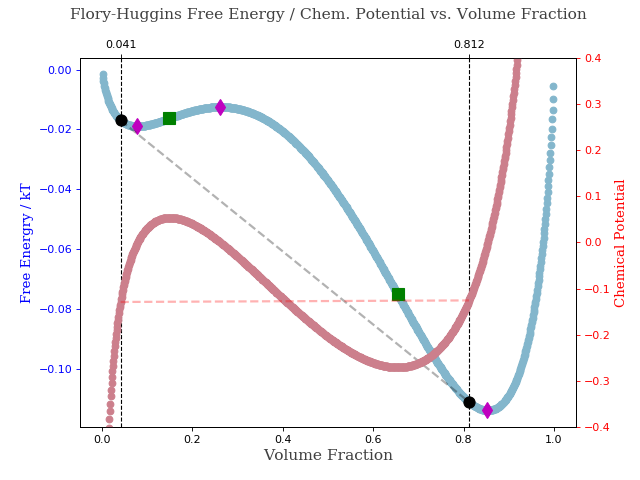

<IPython.core.display.Javascript object>


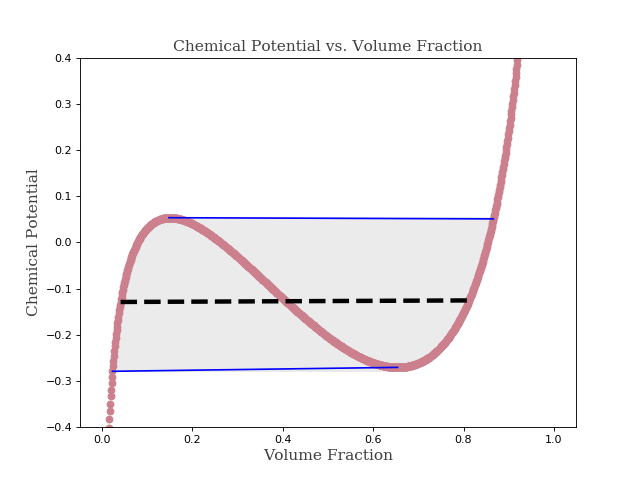

In [3]:
constructPlots(np.arange(0.001,1,0.001), 3, 1.0, 1.7, actuallyPlot=True, isInteractive=False)

In [5]:
chi_s = np.arange(0.10,1.99,0.005)
pts = np.zeros((len(chi_s),4))
for i,chi in enumerate(chi_s):
    pts[i] = constructPlots(np.arange(0.001,1,0.001), 3.0, 1.0, chi, actuallyPlot=False, isInteractive=False)

<IPython.core.display.Javascript object>


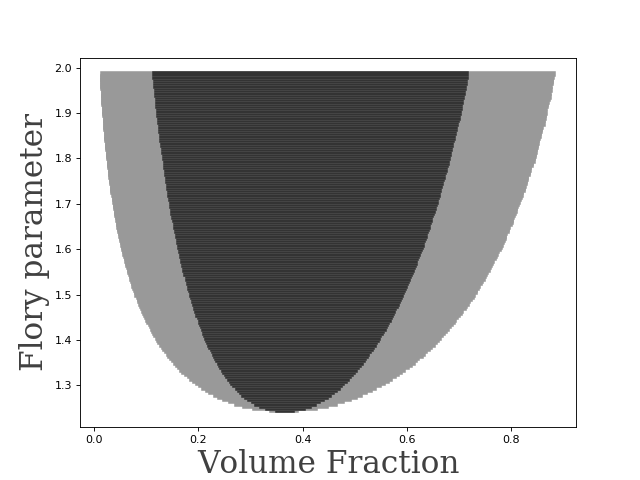

In [11]:
font_plt = {'family': 'serif',
            'color':  '0.25',
            'weight': 'normal',
            'size': 28,
            }

fig3 = plt.figure(3,figsize=(8,6))
for i,pt in enumerate(pts):
    plt.plot(pt[0:2], [chi_s[i], chi_s[i]],c='0.6',lw=5)
    plt.plot(pt[2:4], [chi_s[i], chi_s[i]],c='0.2',lw=5)
plt.xlabel('Volume Fraction', fontdict=font_plt)
#plt.ylabel('Flory interaction parameter', fontdict=font_plt)
plt.ylabel('Flory parameter', fontdict=font_plt)

plt.savefig("phase_diagram.svg",dpi=600)

In [6]:
interact(constructPlots, phi=fixed(np.arange(0.01,1,0.001)), Na=widgets.FloatSlider(min=0.1,max=4,step=0.1,value=2.6),Nb=widgets.FloatSlider(min=0.1,max=10,step=0.5,value=1.0), xi=widgets.FloatSlider(min=0.3,max=2,step=0.01,value=1.56),continuous_update = False)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTIuNiwgZGVzY3JpcHRpb249dSdOYScsIG1heD00LjAsIG1pbj0wLjEpLCBGbG9hdFNsaWRlcih2YWx1ZT0xLjAsIGRlc2PigKY=


<function __main__.constructPlots>